In [1]:
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [2]:
with open('unique_english_words.txt', 'r') as f:
    words = [word.rstrip() for word in f.readlines()] 

SPECIAL_TOKEN = '.'

unique_symbols = sorted(list(set(list(''.join(words)))))
unique_symbols.append(SPECIAL_TOKEN)
print(f'Num of unique symbols: {len(unique_symbols)}')

stoi = {s: i for i, s in enumerate(unique_symbols)}
itos = {i: s for s, i in stoi.items()}

Num of unique symbols: 28


## Split all words into **train**, **val** and **test** datasets

In [3]:
import random

random.seed(23)
random.shuffle(words)

train_split = int(0.8 * len(words))
val_split = int(0.9 * len(words))

train_words = words[:train_split]
val_words = words[train_split:val_split]
test_words = words[val_split:]

print('train:', len(train_words))
print('val:', len(val_words))
print('test:', len(test_words))

train: 758
val: 95
test: 95


## Building a dataset

In [4]:
# build dataset on full data
block_size = 3 # how many characters we are gonna use to predict the next one

def build_dataset(words):
    X = []
    y = []
    
    for word in words:
        word = SPECIAL_TOKEN * block_size + word + SPECIAL_TOKEN
        for i in range(block_size, len(word)):
            context = word[i - block_size:i]
            ch_to_predict = word[i]
    
            X.append([stoi[ch] for ch in context])
            y.append(stoi[ch_to_predict])
    
    X = torch.tensor(X)
    y = torch.tensor(y)

    return X, y


X_train, y_train = build_dataset(train_words)
X_val, y_val = build_dataset(val_words)
X_test, y_test = build_dataset(test_words)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

torch.Size([7182, 3]) torch.Size([7182])
torch.Size([904, 3]) torch.Size([904])
torch.Size([931, 3]) torch.Size([931])


## Initial Model

In [5]:
## INITIAL PARAMS (NO CHANGES FROM PREV NOTEBOOK)
g = torch.Generator().manual_seed(23)

vector_dim = 2
C = torch.randn((len(unique_symbols), vector_dim),             generator = g)

hidden_layer_size = 100
W1 = torch.randn((block_size * vector_dim, hidden_layer_size), generator = g)
b1 = torch.randn((hidden_layer_size,),                         generator = g)
W2 = torch.randn((hidden_layer_size, len(unique_symbols)),     generator = g)
b2 = torch.randn((len(unique_symbols),),                       generator = g)

params = [C, W1, b1, W2, b2]
for p in params:
    p.requires_grad = True

n_iter = 50_000
losses_train = []
losses_val = []
for i in range(n_iter):

    batch_size = 64
    rand_indecies = torch.randint(0, X_train.shape[0], (batch_size, ), generator = g)

    # ---------------forward pass---------------

    emb = C[X_train[rand_indecies, ...]] # shape: [batch_size, block_size, vector_dim]
    h = torch.tanh(emb.view(-1, block_size * vector_dim) @ W1 + b1)
    logits = h @ W2 + b2
    
    loss = F.cross_entropy(logits, y_train[rand_indecies])
    losses_train.append(loss.item())
    
    # ---------------backward pass---------------
    for p in params:
        p.grad = None
    
    loss.backward()
    
    # update
    lr = 0.1 if i < 30_000 else 0.01
    for p in params:
        p.data += -lr * p.grad

    if i % 10_000 == 0:
        print(f'{i}/{n_iter}: {loss:.4f}')

0/50000: 17.1155
10000/50000: 2.5052
20000/50000: 2.5696
30000/50000: 2.4005
40000/50000: 2.3890


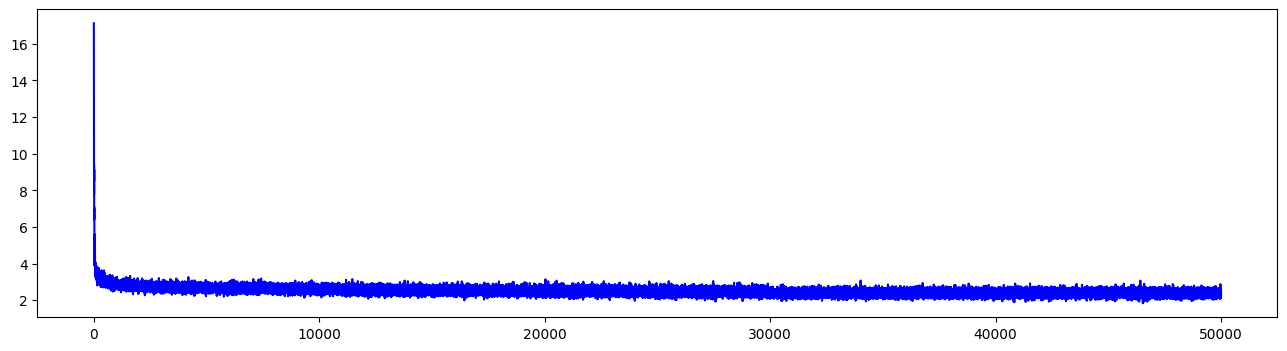

In [6]:
plt.figure(figsize=(16, 4))
plt.plot(range(n_iter), losses_train, 'b')

In [7]:
# training losss
emb = C[X_train]
h = torch.tanh(emb.view(-1, block_size * vector_dim) @ W1 + b1)
logits = h @ W2 + b2
train_loss = F.cross_entropy(logits, y_train)
print(f'train loss: {train_loss.item()}')

# val losss
emb = C[X_val]
h = torch.tanh(emb.view(-1, block_size * vector_dim) @ W1 + b1)
logits = h @ W2 + b2
val_loss = F.cross_entropy(logits, y_val)
print(f'val loss: {val_loss.item()}')

train loss: 2.382155656814575
val loss: 2.5451433658599854


## Improve weights initialization

The loss on the very first iteration (0/50000: **17.1155**) is `way too high`. It is high related to other losses during optimization (it can be easily seen on the plot above: after the first step we rapidly goes down to ~2.5 values) but also related to common sense estimations: `basically at initialization we expect that there is no preferences across all symbols so the weights should be uniformly distributed`. The probability for any next charecter should be 1/28 (num of unique_symbols) ~0.0357. And the loss value should be around:

In [8]:
-torch.tensor(1/28).log() # way smaller than 17.1155!

tensor(3.3322)

One of the reasons why initial loss is so big is that weights initialized randomly (from norm distr) and these values are not uniformly distributed: some of them way to big and some of them way to small.

In [9]:
vector_dim = 2
C = torch.randn((len(unique_symbols), vector_dim),                 generator = g)

hidden_layer_size = 100
W1 = torch.randn((block_size * vector_dim, hidden_layer_size),     generator = g)
b1 = torch.randn((hidden_layer_size,),                             generator = g)

# in order to get smaller logits values (now they quite big)
# we can make weights smaller (and closer to 0. But not = 0!!!!)
W2 = torch.randn((hidden_layer_size, len(unique_symbols)),         generator = g) * 0.01
b2 = torch.randn((len(unique_symbols),),                           generator = g) * 0
    
params = [C, W1, b1, W2, b2]
for p in params:
    p.requires_grad = True

n_iter = 50_000

losses_train = []
losses_val = []
for i in range(n_iter):

    batch_size = 64
    rand_indecies = torch.randint(0, X_train.shape[0], (batch_size, ), generator = g)

    # ---------------forward pass---------------

    emb = C[X_train[rand_indecies, ...]] # shape: [batch_size, block_size, vector_dim]
    h = torch.tanh(emb.view(-1, block_size * vector_dim) @ W1 + b1)
    logits = h @ W2 + b2
    
    loss = F.cross_entropy(logits, y_train[rand_indecies])
    losses_train.append(loss.item())
    
    # ---------------backward pass---------------
    for p in params:
        p.grad = None
    
    loss.backward()
    
    # update
    lr = 0.1 if i < 30_000 else 0.01
    for p in params:
        p.data += -lr * p.grad

    if i % 10_000 == 0:
        print(f'{i}/{n_iter}: {loss:.4f}')

0/50000: 3.3303
10000/50000: 2.2678
20000/50000: 2.2195
30000/50000: 1.9440
40000/50000: 2.2126


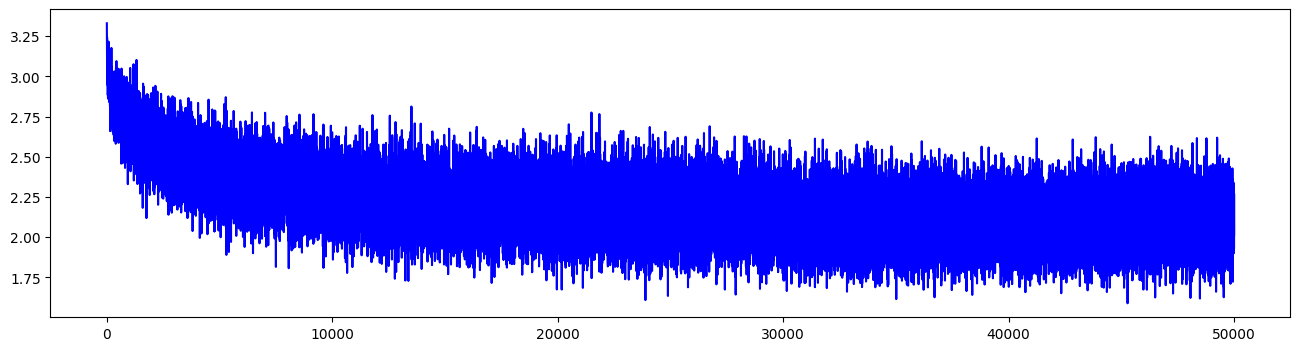

In [10]:
plt.figure(figsize=(16, 4))
plt.plot(range(n_iter), losses_train, 'b')

In [11]:
# training losss
emb = C[X_train]
h = torch.tanh(emb.view(-1, block_size * vector_dim) @ W1 + b1)
logits = h @ W2 + b2
train_loss = F.cross_entropy(logits, y_train)

# val losss
emb = C[X_val]
h = torch.tanh(emb.view(-1, block_size * vector_dim) @ W1 + b1)
logits = h @ W2 + b2
val_loss = F.cross_entropy(logits, y_val)
print(f'{train_loss=}\n{val_loss=}')

train_loss=tensor(2.0916, grad_fn=<NllLossBackward0>)
val_loss=tensor(2.5833, grad_fn=<NllLossBackward0>)


## Fix saturated tanh

In [12]:
# use the code below but run only 1 iter

vector_dim = 2
C = torch.randn((len(unique_symbols), vector_dim),                 generator = g)

hidden_layer_size = 100
W1 = torch.randn((block_size * vector_dim, hidden_layer_size),     generator = g)
b1 = torch.randn((hidden_layer_size,),                             generator = g)

# in order to get smaller logits values (now they quite big)
# we can make weights smaller (and closer to 0. But not = 0!!!!)
W2 = torch.randn((hidden_layer_size, len(unique_symbols)),         generator = g) * 0.01
b2 = torch.randn((len(unique_symbols),),                           generator = g) * 0
    
params = [C, W1, b1, W2, b2]
for p in params:
    p.requires_grad = True

n_iter = 50_000

losses_train = []
losses_val = []
for i in range(n_iter):

    batch_size = 64
    rand_indecies = torch.randint(0, X_train.shape[0], (batch_size, ), generator = g)

    # ---------------forward pass---------------

    emb = C[X_train[rand_indecies, ...]] # shape: [batch_size, block_size, vector_dim]
    hpreact = emb.view(-1, block_size * vector_dim) @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    
    loss = F.cross_entropy(logits, y_train[rand_indecies])
    losses_train.append(loss.item())
    
    # ---------------backward pass---------------
    for p in params:
        p.grad = None
    
    loss.backward()
    
    # update
    lr = 0.1 if i < 30_000 else 0.01
    for p in params:
        p.data += -lr * p.grad

    if i % 10_000 == 0:
        print(f'{i}/{n_iter}: {loss:.4f}')

    break

0/50000: 3.3327


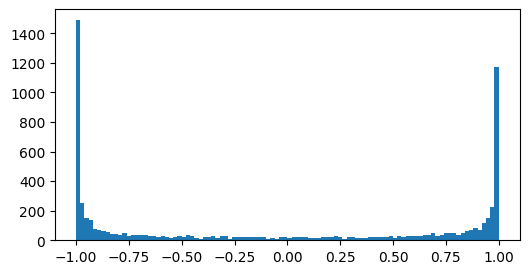

In [13]:
plt.figure(figsize=(6, 3))
plt.hist(h.view(-1).tolist(), bins = 100);
# a lot of saturated values (1 or -1) can be a problem during backprop!

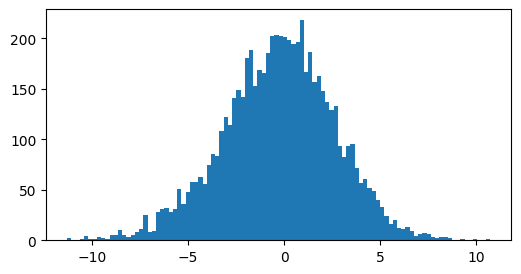

In [14]:
plt.figure(figsize=(6, 3))
plt.hist(hpreact.view(-1).tolist(), bins = 100);
# before applying tanh function values are normally distributed BUT they are too large for tanh function
# this is why we get a lot of saturated outputs!

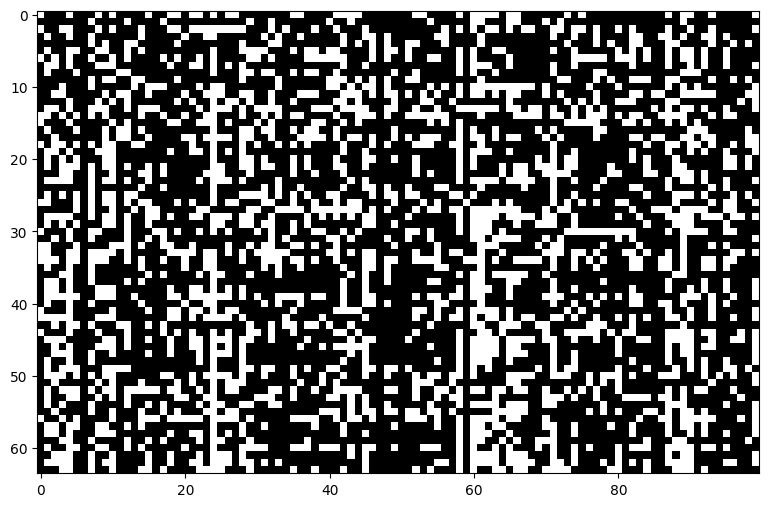

In [15]:
# lets take a look at 'h' variable
plt.figure(figsize=(12, 6))
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation = 'nearest');

# white pixels are saturated neurons! during backpropagation the gradient will be destroyed there

In [16]:
# as we know now 'hpreact' are too extreme for tanh
# how can we get lower (closer to zero) values?

# hpreact = emb.view(-1, block_size * vector_dim) @ W1 + b1
# this part: emb.view(-1, block_size * vector_dim) is taken from C which initially is normally distributed
# at first we can reduce W1 values by multiplying it by 0.1 (and b1 * 0)
 

vector_dim = 2
C = torch.randn((len(unique_symbols), vector_dim),                 generator = g)

hidden_layer_size = 100
W1 = torch.randn((block_size * vector_dim, hidden_layer_size),     generator = g) * 0.2
b1 = torch.randn((hidden_layer_size,),                             generator = g) * 0

# in order to get smaller logits values (now they quite big)
# we can make weights smaller (and closer to 0. But not = 0!!!!)
W2 = torch.randn((hidden_layer_size, len(unique_symbols)),         generator = g) * 0.01
b2 = torch.randn((len(unique_symbols),),                           generator = g) * 0
    
params = [C, W1, b1, W2, b2]
for p in params:
    p.requires_grad = True

n_iter = 50_000

losses_train = []
losses_val = []
for i in range(n_iter):

    batch_size = 64
    rand_indecies = torch.randint(0, X_train.shape[0], (batch_size, ), generator = g)

    # ---------------forward pass---------------

    emb = C[X_train[rand_indecies, ...]] # shape: [batch_size, block_size, vector_dim]
    hpreact = emb.view(-1, block_size * vector_dim) @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    
    loss = F.cross_entropy(logits, y_train[rand_indecies])
    losses_train.append(loss.item())
    
    # ---------------backward pass---------------
    for p in params:
        p.grad = None
    
    loss.backward()
    
    # update
    lr = 0.1 if i < 30_000 else 0.01
    for p in params:
        p.data += -lr * p.grad

    if i % 10_000 == 0:
        print(f'{i}/{n_iter}: {loss:.4f}')

    break

0/50000: 3.3289


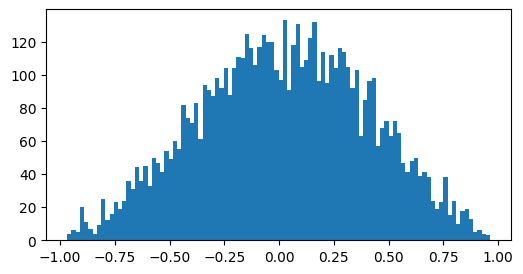

In [17]:
plt.figure(figsize=(6, 3))
plt.hist(h.view(-1).tolist(), bins = 100);
# NICE!

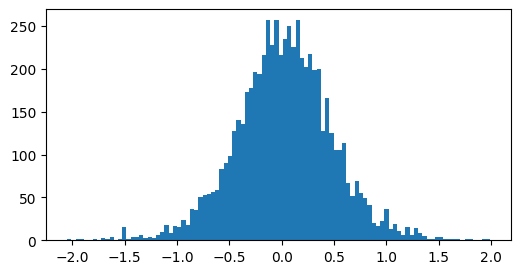

In [18]:
plt.figure(figsize=(6, 3))
plt.hist(hpreact.view(-1).tolist(), bins = 100);

# preactivation values are not so extreme now!
# this is why values after tanh look good

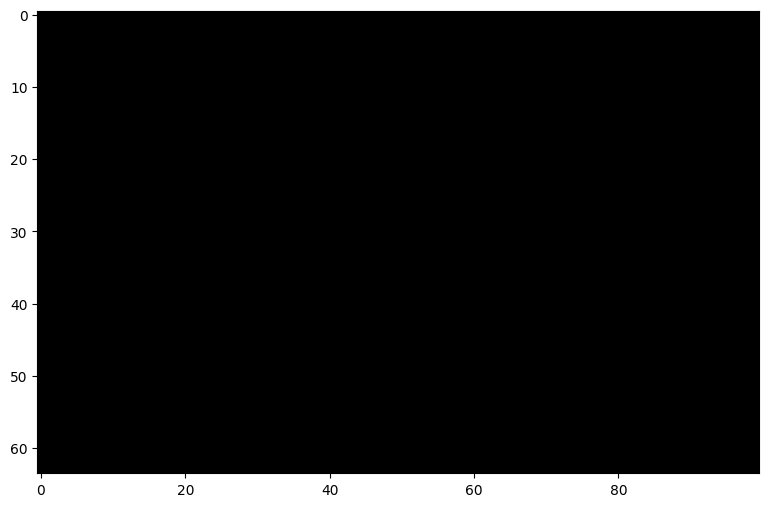

In [19]:
# lets take a look at 'h' variable
plt.figure(figsize=(12, 6))
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation = 'nearest');

# there are no satirated neurons! good for the gradients!

In [20]:
# what std will we have for W1 (Kaiming init)?
(5/3) / (block_size * vector_dim) ** 0.5

0.6804138174397718

In [21]:
# now full training process
vector_dim = 2
C = torch.randn((len(unique_symbols), vector_dim),                 generator = g)

hidden_layer_size = 100
W1 = torch.randn((block_size * vector_dim, hidden_layer_size),     generator = g) * (5/3) / (block_size * vector_dim) ** 0.5
b1 = torch.randn((hidden_layer_size,),                             generator = g) * 0.1

# in order to get smaller logits values (now they quite big)
# we can make weights smaller (and closer to 0. But not = 0!!!!)
W2 = torch.randn((hidden_layer_size, len(unique_symbols)),         generator = g) * 0.01
b2 = torch.randn((len(unique_symbols),),                           generator = g) * 0
    
params = [C, W1, b1, W2, b2]
for p in params:
    p.requires_grad = True

n_iter = 50_000

losses_train = []
losses_val = []
for i in range(n_iter):

    batch_size = 64
    rand_indecies = torch.randint(0, X_train.shape[0], (batch_size, ), generator = g)

    # ---------------forward pass---------------

    emb = C[X_train[rand_indecies, ...]] # shape: [batch_size, block_size, vector_dim]
    hpreact = emb.view(-1, block_size * vector_dim) @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    
    loss = F.cross_entropy(logits, y_train[rand_indecies])
    losses_train.append(loss.item())
    
    # ---------------backward pass---------------
    for p in params:
        p.grad = None
    
    loss.backward()
    
    # update
    lr = 0.1 if i < 30_000 else 0.01
    for p in params:
        p.data += -lr * p.grad

    if i % 10_000 == 0:
        print(f'{i}/{n_iter}: {loss:.4f}')

0/50000: 3.3219
10000/50000: 2.2432
20000/50000: 2.4312
30000/50000: 2.1652
40000/50000: 2.2406


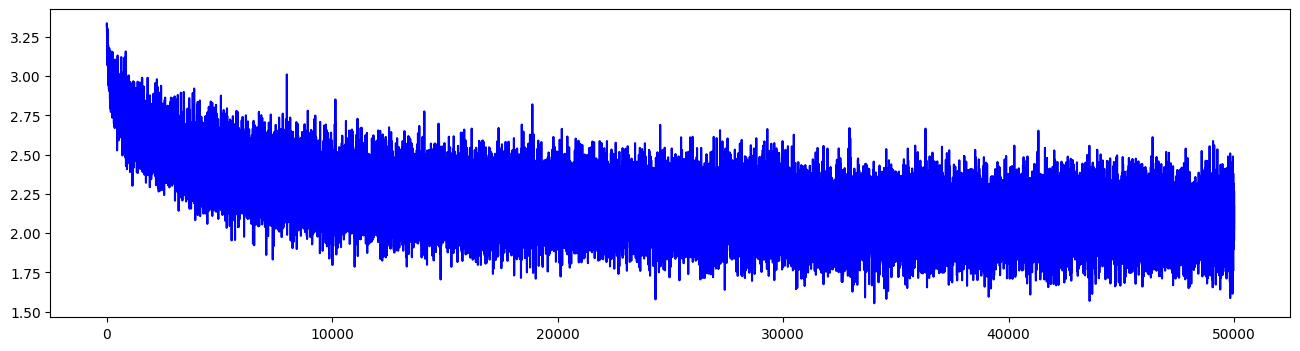

In [22]:
plt.figure(figsize=(16, 4))
plt.plot(range(n_iter), losses_train, 'b')

In [23]:
# training losss
emb = C[X_train]
h = torch.tanh(emb.view(-1, block_size * vector_dim) @ W1 + b1)
logits = h @ W2 + b2
train_loss = F.cross_entropy(logits, y_train)

# val losss
emb = C[X_val]
h = torch.tanh(emb.view(-1, block_size * vector_dim) @ W1 + b1)
logits = h @ W2 + b2
val_loss = F.cross_entropy(logits, y_val)
print(f'{train_loss=}\n{val_loss=}')

train_loss=tensor(2.0759, grad_fn=<NllLossBackward0>)
val_loss=tensor(2.5840, grad_fn=<NllLossBackward0>)


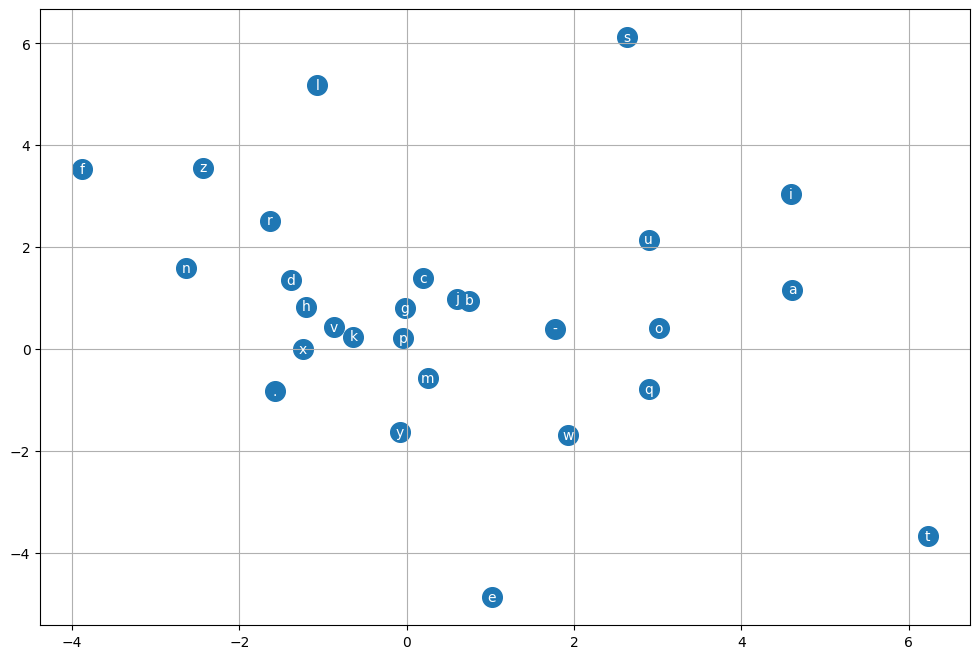

In [24]:
plt.figure(figsize=(12,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

## Predictions

In [25]:
g = torch.Generator().manual_seed(23)

# let's generate some new unique English words!
for i in range(20):
    word = list(SPECIAL_TOKEN * block_size)
    while True:
        context = word[-block_size:]
        context_idx = torch.tensor([stoi[ch] for ch in context])
        
        emb = C[context_idx.view(1, -1)]
        
        h = torch.tanh(emb.view(-1, block_size * vector_dim) @ W1 + b1)
        logits = h @ W2 + b2

        # apply softmax
        counts = logits.exp()
        probs = counts / counts.sum(dim = 1, keepdim = True)

        idx = torch.multinomial(probs, num_samples = 1, replacement = True, generator = g).item()
        if idx == stoi[SPECIAL_TOKEN]: # if we meet special token - it is the end of the word!
            break  
        word.append(itos[idx])

    print(''.join(word))

...ting
...bfeetriveffirar
...flav
...flithony
...woilony
...cobomernity
...soricgert
...eurony
...palingrest
...daphalchinp
...tic
...muyzusmaulolp
...eud
...deal
...wundonestropanten
...purghante
...e-misthsquatethorf
...vapuon
...imfosciilzive
...rumisiter
